<a href="https://colab.research.google.com/github/utyabia/1-notebook/blob/main/Hackathon_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor #or any model of your choice
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
#To get the root mean squared error
'''
rmse=mean_squared_error(y_true,y_pred,squared=False)
'''


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
try:
    train_df = pd.read_csv('/content/train.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


In [52]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [53]:
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(exclude='object').columns
def exploratory_data_analysis(df):
    '''This function performs some preliminary EDA. You are free to add more to it to
       guide you in preparing your dataset for trainiing
    '''
    print("First 5 rows of the dataset:")
    print(df.head())

    # Get information about the dataset (data types, non-null values)
    print("\nDataset information:")
    df.info()

    # Get descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())
    #Get descriptive statistics for categorical columns
    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))
    #Checking for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    # Visualize the distribution of the target variable (price)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()


    # Visualizing the relationship between all numerical features and price
    # For example, 'mileage' and 'price'
    print('Plotting numerical variables vs price')
    numerical_plot=plots(numerical_cols,2,df)


First 5 rows of the dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2     

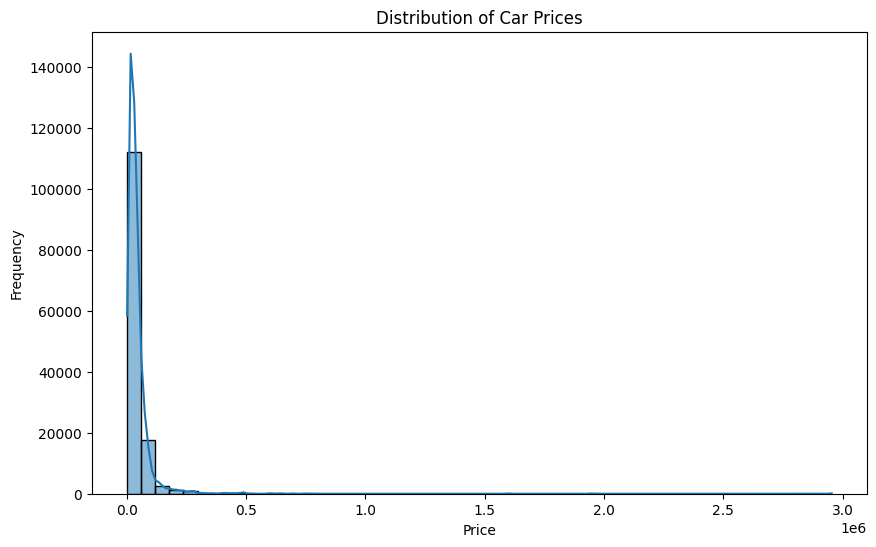

Plotting numerical variables vs price


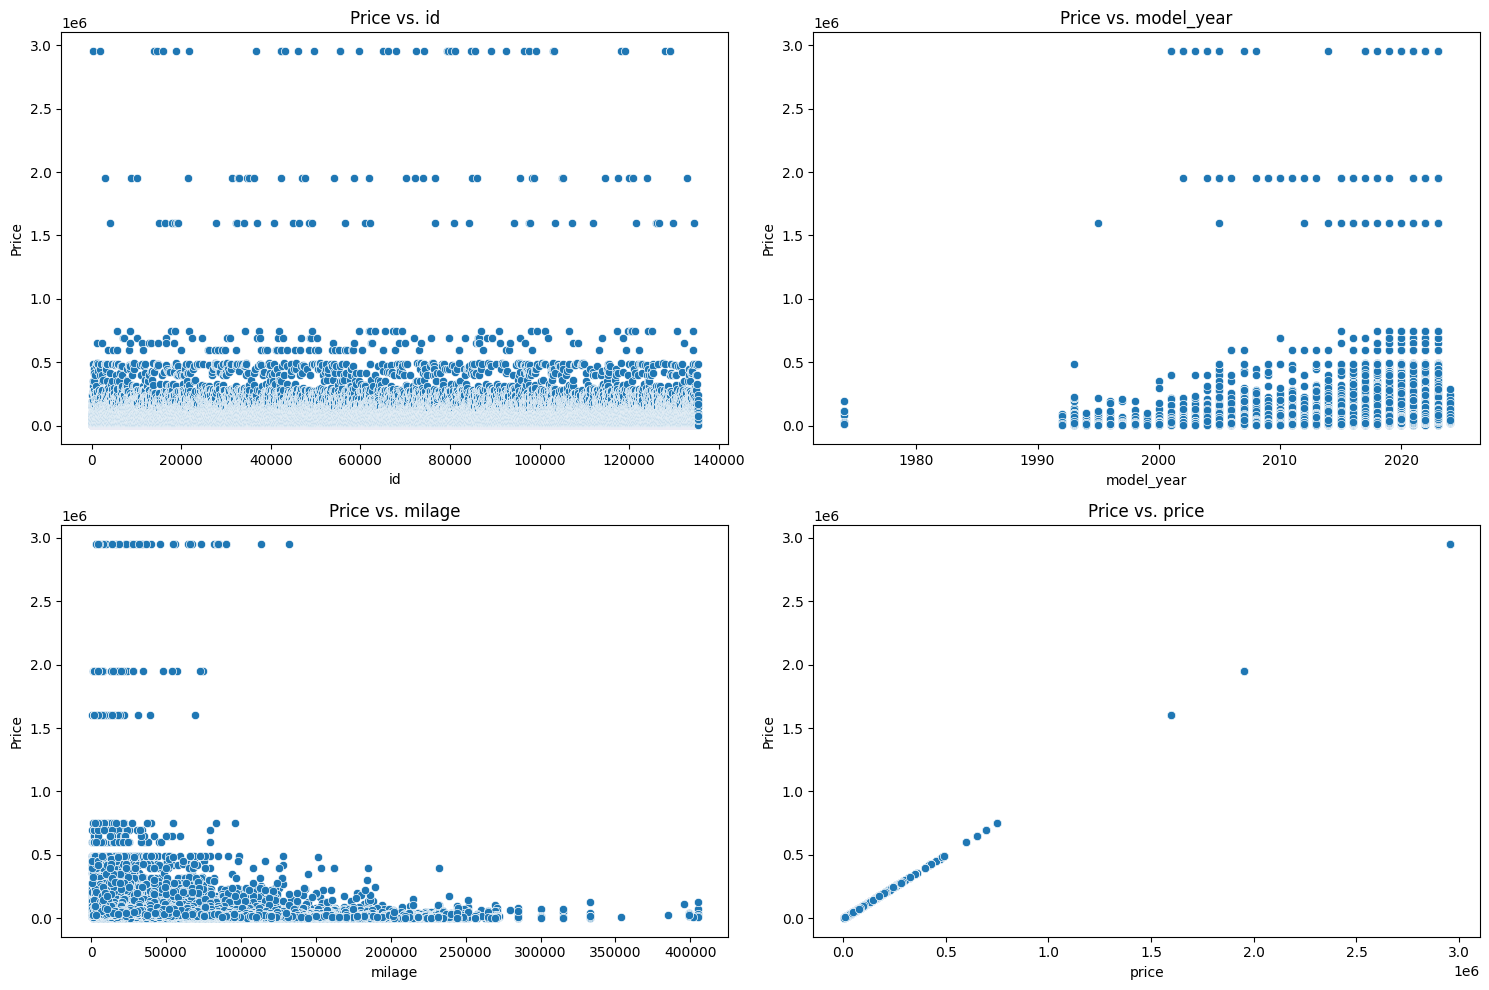

In [54]:
exploratory_data_analysis(train_df)

In [111]:
def filling_missing_values_in_numerical_columns(df, include_price=True):
    print("Inside filling_missing_values_in_numerical_columns...")
    # Clean 'milage' and 'price' columns if they exist and are objects (strings)
    if 'milage' in df.columns and df['milage'].dtype == 'object':
        df['milage'] = df['milage'].str.replace(',', '').str.replace(' mi.', '').astype(float)
    if 'price' in df.columns and df['price'].dtype == 'object' and include_price:
        df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

    numerical_cols_with_missing = ['model_year', 'milage']
    if include_price:
        numerical_cols_with_missing.append('price')

    # Fill missing values using the median of each column
    for col in numerical_cols_with_missing:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]): # Explicitly check if column exists and is numeric
            if df[col].isnull().any():
                median_value = df[col].median()
                df[col].fillna(median_value, inplace=True)

    print("Exiting filling_missing_values_in_numerical_columns.")
    print("DataFrame after filling numerical missing values:")
    print(df.info())
    return df

In [56]:
def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['fuel_type', 'accident', 'clean_title'] # Updated to include all categorical columns with missing values
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            if col in df.columns and df[col].isnull().any(): # Check if column exists and has missing values
                mode_value = df[col].mode()[0]
                df[col].fillna(mode_value, inplace=True)

        print("DataFrame after filling categorical missing values:")
        print(df.info())
        return df

In [64]:
def encode_categorical_columns(df):
    print("Inside encode_categorical_columns...")
    le = LabelEncoder()


    categorical_cols = df.select_dtypes(include='object').columns
    print('Encoding variables...')
    for col in categorical_cols:
        if col == 'price': # Exclude the target variable from encoding
            continue

        if col in df.columns: # Check if column exists before encoding
            try:
                # Fill missing values with a placeholder before checking unique values
                if df[col].isnull().any():
                    df[col].fillna('missing_value_placeholder', inplace=True)

                # Check unique values after handling missing values
                if df[col].nunique() > 1:
                    df[col] = le.fit_transform(df[col])
                    print(f"Successfully applied Label Encoding to: {col}")
                else:
                    print(f"Skipping encoding for '{col}' as it has only one unique value.")

            except Exception as e:
                print(f"Could not apply Label Encoding to {col}. Error: {e}")
    print("Exiting encode_categorical_columns.")
    return df

In [108]:
def preprocessing(df, include_price=True):
    '''
    This function cleans your data for you. Feel free to tweak it to your tastes
    It comprises filling missing data, encoding categorical variables etc
    Perhaps feature engineering as well. Have fun!
    Argument:
        data (pd.DataFrame): The input DataFrame.
        include_price (bool): Whether the 'price' column is present in the DataFrame.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    '''
    print("Starting preprocessing...")
    df=filling_missing_values_in_numerical_columns(df, include_price=include_price)
    print("After filling numerical missing values:")
    print(df.columns)
    df=filling_missing_values_in_categorical_columns(df)
    print("After filling categorical missing values:")
    print(df.columns)
    df=encode_categorical_columns(df)
    print("After encoding categorical variables:")
    print(df.columns)


    # Handle 'price' column if not included
    if not include_price and 'price' in df.columns:
        df = df.drop('price', axis=1)
        print("Dropped 'price' column as include_price is False.")


    return df

In [104]:
train_df = pd.read_csv('/content/train.csv')
df=preprocessing(train_df, include_price=True)

Starting preprocessing...
Inside filling_missing_values_in_numerical_columns...
Exiting filling_missing_values_in_numerical_columns.
DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None
After

/tmp/ipython-input-535214163.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     188533 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      188533 non-null  object
 11  clean_title   188533 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None
After filling categorical missing values:
Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_titl

In [67]:
# Reload train_df and check data types before preprocessing
train_df = pd.read_csv('/content/train.csv')
print("Data types before preprocessing:")
print(train_df[['milage', 'price']].dtypes)

Data types before preprocessing:
milage    int64
price     int64
dtype: object


In [71]:
X = df.drop('price', axis=1) # Replace 'price' with your target column name
y = df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 150826
Testing set size: 37707


In [72]:
print(X_train.head())

            id  brand  model  model_year  milage  fuel_type  engine  \
184031  184031     36    764        2017   61675          1     258   
173831  173831     39    732        2003  185000          2     323   
183819  183819     14    670        2020   92000          2     651   
85525    85525     19    583        2023    5483          2     441   
41872    41872     11    457        2023    5000          2    1093   

        transmission  ext_col  int_col  accident clean_title  
184031            49      128       14         0         Yes  
173831            38      263       71         0         Yes  
183819             2      128       71         0         Yes  
85525             20       29       14         1         Yes  
41872             16      234       14         1         Yes  


Training your Model

In [85]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.base import is_classifier, is_regressor

def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    """
    Perform K-Fold Cross Validation with hyperparameter tuning. Auto-selects scoring if not provided.

    Parameters:
    -----------
    estimator : sklearn estimator
        The model to train (e.g., RandomForestRegressor(), LogisticRegression(), etc.)
    param_grid : dict
        Hyperparameter search space, e.g., {'n_estimators': [100, 200], 'max_depth': [5, 10]}
    X : Features
    y : Target variable
    cv_splits : int
        Number of folds for cross-validation
    scoring : str or callable, or None
        Scoring metric for GridSearchCV. Defaults to 'r2' for regression or 'accuracy' for classification.
    """

    # Auto-detect scoring if not provided
    if scoring is None:
        if is_regressor(estimator):
            scoring = 'r2'   # or make_scorer(mean_squared_error, greater_is_better=False) if you prefer MSE
        elif is_classifier(estimator):
            scoring = 'accuracy'
        else:
            raise ValueError("Could not determine if estimator is classifier or regressor; please pass scoring explicitly.")

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_, grid_search


In [97]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.base import is_classifier, is_regressor

# --- 1. one-hot encode categoricals once outside CV ---
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# If you have NaNs or inf in y_train, filter them
finite_mask = np.isfinite(y_train)
X_train_encoded_finite = X_train_encoded.loc[finite_mask]
y_train_finite = y_train.loc[finite_mask]


# --- 2. model and parameter distributions ---
model = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# --- 3. fast random search instead of full grid search ---
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=6,               # only try 6 random combos instead of all 12
    cv=3,                   # only 3 folds instead of 5
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# --- 4. fit and get results ---
random_search.fit(X_train_encoded_finite, y_train_finite)

best_model = random_search.best_estimator_
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print("Best Params:", best_params)
print("Best Cross-Validation R2:", random_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 5}
Best Cross-Validation R2: 0.1199240154811031


In [98]:
# One-hot encode X_val using the columns from X_train_encoded to ensure feature consistency
X_val_encoded = pd.get_dummies(X_val, drop_first=True)
# Reindex X_val_encoded to match the columns of X_train_encoded, filling missing columns with 0
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


y_val_pred = best_model.predict(X_val_encoded)

val_rmse = mean_squared_error(y_val, y_val_pred)**0.5

print("Validation RMSE:", val_rmse)

Validation RMSE: 68919.12925696348


In [100]:
# Combine X_train and X_val
X_combined = pd.concat([X_train, X_val], ignore_index=True)
y_combined = pd.concat([y_train, y_val], ignore_index=True)

# One-hot encode the combined data, consistent with how X_train_encoded was created
X_combined_encoded = pd.get_dummies(X_combined, drop_first=True)

# Ensure only finite values in y_combined
finite_mask_combined = np.isfinite(y_combined)
X_combined_encoded_finite = X_combined_encoded.loc[finite_mask_combined]
y_combined_finite = y_combined.loc[finite_mask_combined]


final_model = RandomForestRegressor(**best_params,random_state=42)

final_model.fit(X_combined_encoded_finite, y_combined_finite)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)

In [101]:
test=pd.read_csv("/content/test.csv")
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [112]:
test=pd.read_csv("/content/test.csv")
X_test=preprocessing(test, include_price=False)
X_test.head()

Starting preprocessing...
Inside filling_missing_values_in_numerical_columns...
Exiting filling_missing_values_in_numerical_columns.
DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB
None
After filling numerical missing values:
Index(['

/tmp/ipython-input-535214163.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     125690 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      125690 non-null  object
 11  clean_title   125690 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB
None
After filling categorical missing values:
Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')
Inside encode_ca

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,26,1388,2015,98000,2,326,16,302,10,1,Yes
1,188534,26,1375,2020,9142,3,787,31,261,14,1,Yes
2,188535,14,636,2022,28121,2,541,3,302,57,1,Yes
3,188536,3,182,2016,61258,2,193,39,259,14,1,Yes
4,188537,3,181,2018,59000,2,365,38,127,14,1,Yes


In [113]:
# One-hot encode X_test using the columns from X_combined_encoded to ensure feature consistency
X_test_encoded = pd.get_dummies(X_test, drop_first=True)
# Reindex X_test_encoded to match the columns of X_combined_encoded, filling missing columns with 0
X_test_encoded = X_test_encoded.reindex(columns=X_combined_encoded.columns, fill_value=0)


y_test_pred = final_model.predict(X_test_encoded)
y_test_pred[0:5]

array([17420.07236156, 77220.73458509, 63765.8580259 , 23905.29962108,
       31443.70436804])

In [114]:
submission=pd.DataFrame({"id":X_test.index,"Price":y_test_pred})
submission.to_csv("Submission.csv",index=False)